In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_validate
)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

### Reading the data

In [3]:
df = pd.read_csv("../data/raw/cc_default.csv")

### Data Wrangling

In [4]:
# Dropping unrelated columns

df.drop(columns=["ID"], inplace=True)

In [5]:
# Renaming columns

df.rename(columns={
    "default payment next month": "is_default",
    "PAY_0":"PAY_1"
}, inplace=True)

In [6]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,is_default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Data Splitting

In [7]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   LIMIT_BAL   24000 non-null  int64
 1   SEX         24000 non-null  int64
 2   EDUCATION   24000 non-null  int64
 3   MARRIAGE    24000 non-null  int64
 4   AGE         24000 non-null  int64
 5   PAY_1       24000 non-null  int64
 6   PAY_2       24000 non-null  int64
 7   PAY_3       24000 non-null  int64
 8   PAY_4       24000 non-null  int64
 9   PAY_5       24000 non-null  int64
 10  PAY_6       24000 non-null  int64
 11  BILL_AMT1   24000 non-null  int64
 12  BILL_AMT2   24000 non-null  int64
 13  BILL_AMT3   24000 non-null  int64
 14  BILL_AMT4   24000 non-null  int64
 15  BILL_AMT5   24000 non-null  int64
 16  BILL_AMT6   24000 non-null  int64
 17  PAY_AMT1    24000 non-null  int64
 18  PAY_AMT2    24000 non-null  int64
 19  PAY_AMT3    24000 non-null  int64
 20  PAY_AMT4    24000 non-nu

### Feature Engineering


#### Approach (TODO):

- ~~Create new columns for percent of bill amount paid~~
- Group the 5 & 6  categories of education into one "unknown"
- Assumptions for Education and Marriage
- Deal with class imbalance
- ~~Create new column wrt to credit utilization~~
- Repayment status



In [9]:
def preprocess(df):

    # Percent Bill Paid
    for i in range(1, 6):
        df[f"percent_paid{i}"] = df[f"PAY_AMT{i}"] / df[f"BILL_AMT{i + 1}"] * 100
        df[f"percent_paid{i}"][df[f"percent_paid{i}"] < 0] = 100 - (df[f"percent_paid{i}"])
        df[f"percent_paid{i}"][df[f"BILL_AMT{i + 1}"] == 0] = 100 + df[f"PAY_AMT{i}"] * 0.01


    # Precent Credit Utilized
    for i in range(1, 7):
        df[f"percent_credit_utilised{i}"] = df[f"BILL_AMT{i}"] / df[f"LIMIT_BAL"] * 100


    # Standard Deviations
    bill_amt_col_names = []
    pay_amt_col_names = []

    for i in range(1, 7):
        bill_amt_col_names.append(f"BILL_AMT{i}")
        pay_amt_col_names.append(f"PAY_AMT{i}")

    df["std_dev_bill"] = df[bill_amt_col_names].std(axis=1)
    df["std_dev_pay"] = df[pay_amt_col_names].std(axis=1)


    # Change Education categories 0, 5 and 6 to 4
    df["EDUCATION"].replace({5: 4, 6: 4, 0: 4}, inplace=True)


    # Change PAY_X values from -2 to 0
    for i in range(1, 7):
        df[f"PAY_{i}"].replace({-2: 0}, inplace=True)

    return df

In [10]:
train_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,is_default
19682,200000,2,2,1,46,0,0,0,0,0,...,103422,95206,65108,3692,5000,3300,2500,2930,1500,0
11062,120000,2,1,1,32,-1,-1,-1,-1,-1,...,476,802,326,652,326,476,802,0,326,1
197,20000,2,1,2,22,0,0,0,0,-1,...,8332,18868,19247,1500,1032,541,20000,693,1000,0
23620,100000,2,5,2,34,0,0,0,0,0,...,23181,7721,3219,5004,3811,3002,4000,3219,1864,0
26031,290000,2,2,2,29,0,0,0,0,0,...,8770,9145,10016,1130,1502,1300,500,1000,1001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,380000,2,2,1,37,0,0,0,0,0,...,14291,15949,15556,1204,1300,1242,1900,0,3000,0
17730,360000,2,1,1,54,1,-2,-2,-1,0,...,2580,2580,6941,0,0,2580,0,6941,0,0
28030,50000,2,3,1,29,0,0,0,0,0,...,39420,8824,9009,2002,2000,1530,1000,327,329,1
15725,30000,2,2,2,21,0,0,0,0,0,...,30841,29434,16565,2000,2000,2000,1765,331,0,0


In [11]:
train_df = preprocess(train_df)

/tmp/ipykernel_118560/1558858417.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"percent_paid{i}"][df[f"percent_paid{i}"] < 0] = 100 - (df[f"percent_paid{i}"])
/tmp/ipykernel_118560/1558858417.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"percent_paid{i}"][df[f"BILL_AMT{i + 1}"] == 0] = 100 + df[f"PAY_AMT{i}"] * 0.01


In [12]:
train_df

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,percent_paid4,percent_paid5,percent_credit_utilised1,percent_credit_utilised2,percent_credit_utilised3,percent_credit_utilised4,percent_credit_utilised5,percent_credit_utilised6,std_dev_bill,std_dev_pay
19682,200000,2,2,1,46,0,0,0,0,0,...,2.625885,4.500215,53.325500,51.586500,52.068500,51.711000,47.603000,32.554000,15752.198036,1177.461960
11062,120000,2,1,1,32,-1,-1,-1,-1,-1,...,100.000000,0.000000,2.963333,0.271667,0.271667,0.396667,0.668333,0.271667,1280.925707,281.536972
197,20000,2,1,2,22,0,0,0,0,-1,...,105.999576,3.600561,92.765000,97.230000,95.325000,41.660000,94.340000,96.235000,4380.664033,7782.829323
23620,100000,2,4,2,34,0,0,0,0,0,...,51.806761,100.000000,91.674000,91.348000,87.244000,23.181000,7.721000,3.219000,43647.501305,1059.295174
26031,290000,2,2,2,29,0,0,0,0,0,...,5.467469,9.984026,2.525517,2.818621,2.892759,3.024138,3.153448,3.453793,914.027717,339.899054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28636,380000,2,2,1,37,0,0,0,0,0,...,11.912973,0.000000,3.530263,3.784474,3.493947,3.760789,4.197105,4.093684,1090.199324,983.188080
17730,360000,2,1,1,54,1,0,0,-1,0,...,0.000000,100.000000,0.000000,0.000000,0.000000,0.716667,0.716667,1.928056,2723.401580,2818.710373
28030,50000,2,3,1,29,0,0,0,0,0,...,11.332729,3.629704,94.388000,96.762000,93.554000,78.840000,17.648000,18.018000,19124.249766,768.485524
15725,30000,2,2,2,21,0,0,0,0,0,...,5.996467,1.998189,94.696667,95.100000,98.116667,102.803333,98.113333,55.216667,5283.495724,927.424750


In [13]:
test_df = preprocess(test_df)

/tmp/ipykernel_118560/1558858417.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"percent_paid{i}"][df[f"percent_paid{i}"] < 0] = 100 - (df[f"percent_paid{i}"])
/tmp/ipykernel_118560/1558858417.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"percent_paid{i}"][df[f"BILL_AMT{i + 1}"] == 0] = 100 + df[f"PAY_AMT{i}"] * 0.01


### Feature Types

In [14]:
X_train, y_train = train_df.drop(columns=["is_default"]), train_df["is_default"]
X_test, y_test = test_df.drop(columns=["is_default"]), test_df["is_default"]

In [15]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   LIMIT_BAL                 24000 non-null  int64  
 1   SEX                       24000 non-null  int64  
 2   EDUCATION                 24000 non-null  int64  
 3   MARRIAGE                  24000 non-null  int64  
 4   AGE                       24000 non-null  int64  
 5   PAY_1                     24000 non-null  int64  
 6   PAY_2                     24000 non-null  int64  
 7   PAY_3                     24000 non-null  int64  
 8   PAY_4                     24000 non-null  int64  
 9   PAY_5                     24000 non-null  int64  
 10  PAY_6                     24000 non-null  int64  
 11  BILL_AMT1                 24000 non-null  int64  
 12  BILL_AMT2                 24000 non-null  int64  
 13  BILL_AMT3                 24000 non-null  int64  
 14  BI

In [16]:
categorical_features = [
    "SEX",
    "EDUCATION",
    "MARRIAGE"
]

pass_through_features = [
    "PAY_1",
    "PAY_2",
    "PAY_3",
    "PAY_4",
    "PAY_5",
    "PAY_6"
]

numerical_features = list(set(X_train.columns) -
                          set(categorical_features) -
                          set(pass_through_features))


In [17]:
assert len(numerical_features) + len(categorical_features) + len(pass_through_features) == len(X_train.columns)

### Model

In [18]:
scalar = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [19]:
preprocessor = make_column_transformer(
    (scalar, numerical_features),
    (ohe, categorical_features),
    ("passthrough", pass_through_features)
)

In [20]:
preprocessor.fit(X_train);

In [21]:
new_columns = numerical_features + preprocessor.named_transformers_[
    "onehotencoder"
].get_feature_names_out().tolist() + pass_through_features

In [22]:
# Credits to Varada K.

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [23]:
scoring_metrics = [
    "roc_auc",
    "f1",
    "recall",
    "precision"
]

In [24]:
dummy = DummyClassifier()
pipe_dummy = make_pipeline(preprocessor, dummy)

In [25]:
results = {}
results_base = {}

In [26]:
results_base["dummy"] = mean_std_cross_val_scores(
    pipe_dummy,
    X_train,
    y_train,
    cv=10,
    return_train_score=True,
    scoring=scoring_metrics
)

/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/u

In [27]:
pd.DataFrame(results)

""


__Models to test__ 
1) Logistic 
2) SVC
4) Decision Tree
5) Random Forest
6) XGBoost
7) LGBM 
8) CatBoost
9) Naive Bayes

In [28]:
# Base models with default hyper-parameters

models = {
    "Decision Tree": make_pipeline(preprocessor, DecisionTreeClassifier()),
    "SVC": make_pipeline(preprocessor, SVC()),
    "Logistic Regression": make_pipeline(preprocessor, LogisticRegression(max_iter=10000)),
    "Random Forest": make_pipeline(preprocessor, RandomForestClassifier()),
    "XGBoost": make_pipeline(preprocessor, XGBClassifier(verbosity=0)),
    "LGBM": make_pipeline(preprocessor, LGBMClassifier()),
    "CatBoost": make_pipeline(preprocessor, CatBoostClassifier(verbose=0)),
    "Naive Bayes": make_pipeline(preprocessor, GaussianNB())
}

In [29]:
for model_name, model in models.items():

    results_base[model_name] = mean_std_cross_val_scores(
        model,
        X_train,
        y_train,
        cv=10,
        n_jobs=-1,
        return_train_score=True,
        scoring=scoring_metrics
    )

    print(model_name, "done!")

Decision Tree done!


/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/u

SVC done!


/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Logistic Regression done!
Random Forest done!


/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/utkarshsaboo

XGBoost done!
LGBM done!


/home/utkarshsaboo45/miniconda3/envs/env_cc_default/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CatBoost done!
Naive Bayes done!


In [30]:
pd.DataFrame(results_base)

,dummy,Decision Tree,SVC,Logistic Regression,Random Forest,XGBoost,LGBM,CatBoost,Naive Bayes
fit_time,0.039 (+/- 0.008),1.737 (+/- 0.296),98.677 (+/- 19.998),0.971 (+/- 0.254),17.720 (+/- 2.999),452.450 (+/- 149.944),981.195 (+/- 363.988),99.341 (+/- 47.580),0.070 (+/- 0.013)
score_time,0.021 (+/- 0.002),0.038 (+/- 0.018),9.629 (+/- 2.310),0.052 (+/- 0.031),0.269 (+/- 0.074),0.324 (+/- 0.158),0.273 (+/- 0.145),0.154 (+/- 0.098),0.032 (+/- 0.008)
test_roc_auc,0.500 (+/- 0.000),0.575 (+/- 0.014),0.656 (+/- 0.017),0.686 (+/- 0.017),0.717 (+/- 0.014),0.717 (+/- 0.014),0.736 (+/- 0.013),0.738 (+/- 0.014),0.627 (+/- 0.011)
train_roc_auc,0.500 (+/- 0.000),1.000 (+/- 0.000),0.768 (+/- 0.003),0.689 (+/- 0.002),1.000 (+/- 0.000),0.951 (+/- 0.003),0.875 (+/- 0.002),0.882 (+/- 0.001),0.629 (+/- 0.002)
test_f1,0.000 (+/- 0.000),0.342 (+/- 0.022),0.001 (+/- 0.002),0.015 (+/- 0.009),0.322 (+/- 0.011),0.329 (+/- 0.013),0.335 (+/- 0.022),0.333 (+/- 0.018),0.374 (+/- 0.003)
train_f1,0.000 (+/- 0.000),0.998 (+/- 0.000),0.009 (+/- 0.001),0.015 (+/- 0.002),0.998 (+/- 0.000),0.692 (+/- 0.011),0.484 (+/- 0.008),0.530 (+/- 0.003),0.375 (+/- 0.001)
test_recall,0.000 (+/- 0.000),0.354 (+/- 0.028),0.000 (+/- 0.001),0.008 (+/- 0.004),0.226 (+/- 0.011),0.240 (+/- 0.012),0.235 (+/- 0.019),0.232 (+/- 0.017),0.966 (+/- 0.008)
train_recall,0.000 (+/- 0.000),0.996 (+/- 0.000),0.005 (+/- 0.001),0.008 (+/- 0.001),0.997 (+/- 0.000),0.558 (+/- 0.013),0.347 (+/- 0.008),0.388 (+/- 0.003),0.967 (+/- 0.003)
test_precision,0.000 (+/- 0.000),0.331 (+/- 0.019),0.200 (+/- 0.422),0.516 (+/- 0.149),0.562 (+/- 0.014),0.524 (+/- 0.021),0.583 (+/- 0.030),0.590 (+/- 0.020),0.232 (+/- 0.002)
train_precision,0.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.580 (+/- 0.030),0.999 (+/- 0.000),0.912 (+/- 0.006),0.804 (+/- 0.008),0.836 (+/- 0.005),0.232 (+/- 0.001)


In [31]:
# Logistic Regresion
param_lr = {
    "logisticregression__class_weight": ['balanced', None],
    "logisticregression__C": 10.0 ** np.arange(-2, 4)
}

pipe_lr = make_pipeline(preprocessor, LogisticRegression(max_iter=10000))

random_search = RandomizedSearchCV(
    pipe_lr,
    param_lr,
    n_jobs=-1,
    return_train_score=True,
    scoring=scoring_metrics,
    refit="recall"
)

In [32]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['std_dev_bill',
                                                                                'PAY_AMT2',
                                                                                'BILL_AMT1',
                                                                                'BILL_AMT5',
                                                                                'percent_paid5',
                                                                                'percent_credit_utilised5',
                                                                                'std_dev_pay',
                                                                 

In [33]:
pd.DataFrame(random_search.cv_results_)[[
    "mean_fit_time",
    "param_logisticregression__class_weight",
    "param_logisticregression__C",
    "mean_train_recall",
    "mean_test_recall",
    "mean_train_precision",
    "mean_test_precision",
    "mean_train_f1",
    "mean_test_f1"
]].sort_values("mean_test_recall", ascending=False).set_index("mean_test_recall").T

mean_test_recall,0.702544,0.701981,0.701794,0.701794,0.697856,0.007128,0.006940,0.006940,0.005627,0.001313
mean_fit_time,1.153051,1.525742,1.309146,1.597168,0.800992,1.302613,1.53267,1.658229,0.749714,0.34313
param_logisticregression__class_weight,balanced,balanced,balanced,balanced,balanced,None,None,None,None,None
param_logisticregression__C,1.0,100.0,10.0,1000.0,0.1,10.0,1.0,100.0,0.1,0.01
mean_train_recall,0.707192,0.707848,0.707848,0.707755,0.702644,0.007736,0.007689,0.007689,0.006236,0.001641
mean_train_precision,0.312583,0.312612,0.312568,0.312584,0.313173,0.585055,0.589334,0.581899,0.629703,0.557546
mean_test_precision,0.310479,0.31029,0.310174,0.310233,0.311175,0.509817,0.49956,0.502124,0.486147,0.516667
mean_train_f1,0.433529,0.43368,0.433637,0.433635,0.433238,0.01527,0.01518,0.015178,0.012349,0.003272
mean_test_f1,0.430581,0.430296,0.43015,0.430205,0.430361,0.014051,0.013682,0.013682,0.011121,0.002619


In [34]:
random_search.best_params_

{'logisticregression__class_weight': 'balanced', 'logisticregression__C': 1.0}

In [35]:
pipe_lr_balanced = make_pipeline(
    preprocessor,
    LogisticRegression(
        class_weight=random_search.best_params_["logisticregression__class_weight"],
        C=random_search.best_params_["logisticregression__C"],
        max_iter=10000
    )
)

In [36]:
pipe_lr_balanced.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['std_dev_bill', 'PAY_AMT2',
                                                   'BILL_AMT1', 'BILL_AMT5',
                                                   'percent_paid5',
                                                   'percent_credit_utilised5',
                                                   'std_dev_pay',
                                                   'percent_credit_utilised2',
                                                   'PAY_AMT3',
                                                   'percent_credit_utilised6',
                                                   'PAY_AMT6',
                                                   'percent_credit_utilised1',
                                                   'percent_paid4', 'PAY_AMT5',
              

In [37]:
importances = pd.DataFrame(
    pipe_lr_balanced.named_steps["logisticregression"].coef_,
    columns=new_columns
).T

importances["abs_coef"] = np.abs(importances[0])

importances.sort_values(by="abs_coef", ascending=False, inplace=True)

importances

,0,abs_coef
std_dev_pay,1.238984,1.238984
EDUCATION_4,-0.897428,0.897428
PAY_AMT2,-0.799276,0.799276
PAY_AMT1,-0.701726,0.701726
percent_paid3,-0.601449,0.601449
PAY_AMT3,-0.586687,0.586687
PAY_AMT6,-0.551620,0.551620
MARRIAGE_0,-0.486906,0.486906
PAY_AMT4,-0.481035,0.481035
PAY_AMT5,-0.449446,0.449446


In [38]:
pipe_nb = make_pipeline(preprocessor, GaussianNB())

pipe_nb.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['std_dev_bill', 'PAY_AMT2',
                                                   'BILL_AMT1', 'BILL_AMT5',
                                                   'percent_paid5',
                                                   'percent_credit_utilised5',
                                                   'std_dev_pay',
                                                   'percent_credit_utilised2',
                                                   'PAY_AMT3',
                                                   'percent_credit_utilised6',
                                                   'PAY_AMT6',
                                                   'percent_credit_utilised1',
                                                   'percent_paid4', 'PAY_AMT5',
              

In [39]:
# Tree Based Model

pipe_catboost = make_pipeline(
    preprocessor,
    CatBoostClassifier(
        verbose=0,
        random_state=123,
        auto_class_weights="Balanced"
    )
)

pipe_lgbm = make_pipeline(
    preprocessor,
    LGBMClassifier(random_state=123, class_weight="balanced")
)

In [40]:
models_bal = {
    "Logistic": pipe_lr_balanced,
    "Catboost": pipe_catboost,
    "LGBM": pipe_lgbm,
    "Naive Bayes": pipe_nb
}

In [41]:
for name, value in models_bal.items():
    results[name] = mean_std_cross_val_scores(
        value,
        X_train,
        y_train,
        cv=10,
        n_jobs=-1,
        return_train_score=True,
        scoring=scoring_metrics
    )

    print(name, "done!")

Logistic done!
Catboost done!
LGBM done!
Naive Bayes done!


In [42]:
pd.DataFrame(results).T

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
Logistic,1.410 (+/- 0.450),0.028 (+/- 0.008),0.680 (+/- 0.018),0.684 (+/- 0.002),0.431 (+/- 0.015),0.433 (+/- 0.002),0.702 (+/- 0.029),0.707 (+/- 0.004),0.311 (+/- 0.011),0.312 (+/- 0.001)
Catboost,100.326 (+/- 48.006),0.380 (+/- 0.226),0.736 (+/- 0.014),0.899 (+/- 0.001),0.481 (+/- 0.019),0.666 (+/- 0.002),0.582 (+/- 0.026),0.830 (+/- 0.003),0.410 (+/- 0.016),0.556 (+/- 0.002)
LGBM,145.106 (+/- 228.416),0.176 (+/- 0.065),0.734 (+/- 0.017),0.872 (+/- 0.002),0.477 (+/- 0.022),0.627 (+/- 0.003),0.594 (+/- 0.035),0.797 (+/- 0.004),0.399 (+/- 0.016),0.517 (+/- 0.005)
Naive Bayes,0.065 (+/- 0.013),0.029 (+/- 0.006),0.627 (+/- 0.011),0.629 (+/- 0.002),0.374 (+/- 0.003),0.375 (+/- 0.001),0.966 (+/- 0.008),0.967 (+/- 0.003),0.232 (+/- 0.002),0.232 (+/- 0.001)


In [43]:
# Stacking Classifier

stacking_model = StackingClassifier(
    estimators=list(models_bal.items()),
    final_estimator=LogisticRegression()
)

results["stacking"] = mean_std_cross_val_scores(
    stacking_model,
    X_train,
    y_train,
    cv=10,
    n_jobs=-1,
    return_train_score=True,
    scoring=scoring_metrics
)

In [44]:
# Voting Classifier

pipe_averaging = VotingClassifier(
    list(models_bal.items()), voting="soft"
)

results["pipe_averaging"] = mean_std_cross_val_scores(
    pipe_averaging,
    X_train,
    y_train,
    cv=10,
    n_jobs=-1,
    return_train_score=True,
    scoring=scoring_metrics
)

In [45]:
pd.DataFrame(results).T

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
Logistic,1.410 (+/- 0.450),0.028 (+/- 0.008),0.680 (+/- 0.018),0.684 (+/- 0.002),0.431 (+/- 0.015),0.433 (+/- 0.002),0.702 (+/- 0.029),0.707 (+/- 0.004),0.311 (+/- 0.011),0.312 (+/- 0.001)
Catboost,100.326 (+/- 48.006),0.380 (+/- 0.226),0.736 (+/- 0.014),0.899 (+/- 0.001),0.481 (+/- 0.019),0.666 (+/- 0.002),0.582 (+/- 0.026),0.830 (+/- 0.003),0.410 (+/- 0.016),0.556 (+/- 0.002)
LGBM,145.106 (+/- 228.416),0.176 (+/- 0.065),0.734 (+/- 0.017),0.872 (+/- 0.002),0.477 (+/- 0.022),0.627 (+/- 0.003),0.594 (+/- 0.035),0.797 (+/- 0.004),0.399 (+/- 0.016),0.517 (+/- 0.005)
Naive Bayes,0.065 (+/- 0.013),0.029 (+/- 0.006),0.627 (+/- 0.011),0.629 (+/- 0.002),0.374 (+/- 0.003),0.375 (+/- 0.001),0.966 (+/- 0.008),0.967 (+/- 0.003),0.232 (+/- 0.002),0.232 (+/- 0.001)
stacking,1565.466 (+/- 1404.732),0.542 (+/- 0.291),0.739 (+/- 0.016),0.884 (+/- 0.001),0.327 (+/- 0.016),0.449 (+/- 0.010),0.224 (+/- 0.015),0.317 (+/- 0.010),0.607 (+/- 0.021),0.770 (+/- 0.005)
pipe_averaging,269.283 (+/- 244.689),0.542 (+/- 0.214),0.735 (+/- 0.016),0.853 (+/- 0.001),0.433 (+/- 0.005),0.476 (+/- 0.001),0.875 (+/- 0.009),0.954 (+/- 0.003),0.288 (+/- 0.004),0.317 (+/- 0.001)


In [46]:
# Credits to Varada K.

def plot_roc_curve(model, X, y):
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:, 1])
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR (recall)")

    default_threshold = np.argmin(np.abs(thresholds - 0.5))

    plt.plot(
        fpr[default_threshold],
        tpr[default_threshold],
        "or",
        markersize=10,
        label="threshold 0.5",
    )
    plt.legend(loc="best");

In [47]:
# Credits to Varada K.

def plot_PR_curve(
    precision,
    recall,
    close_default,
    label="PR curve",
    marker_colour="r",
    marker_label="Default threshold",
):
    plt.plot(precision, recall, label=label)
    plt.xlabel("Precision")
    plt.ylabel("Recall")
    plt.plot(
        precision[close_default],
        recall[close_default],
        "o",
        markersize=12,
        label=marker_label,
        c=marker_colour,
    )
    plt.legend(loc="best");

In [48]:
pipe_averaging.fit(X_train, y_train)

VotingClassifier(estimators=[('Logistic',
                              Pipeline(steps=[('columntransformer',
                                               ColumnTransformer(transformers=[('standardscaler',
                                                                                StandardScaler(),
                                                                                ['std_dev_bill',
                                                                                 'PAY_AMT2',
                                                                                 'BILL_AMT1',
                                                                                 'BILL_AMT5',
                                                                                 'percent_paid5',
                                                                                 'percent_credit_utilised5',
                                                                                 'std_dev_pay',
             

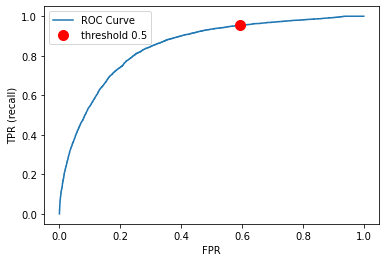

In [49]:
plot_roc_curve(pipe_averaging, X_train, y_train)

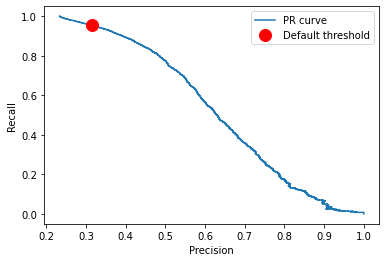

In [50]:
precision_avg, recall_avg, thresholds_avg = precision_recall_curve(
    y_train, pipe_averaging.predict_proba(X_train)[:, 1]
)

close_default_avg = np.argmin(np.abs(thresholds_avg - 0.5))

plot_PR_curve(precision_avg, recall_avg, close_default_avg)

In [51]:
# pipe_lr_balanced.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['std_dev_bill', 'PAY_AMT2',
                                                   'BILL_AMT1', 'BILL_AMT5',
                                                   'percent_paid5',
                                                   'percent_credit_utilised5',
                                                   'std_dev_pay',
                                                   'percent_credit_utilised2',
                                                   'PAY_AMT3',
                                                   'percent_credit_utilised6',
                                                   'PAY_AMT6',
                                                   'percent_credit_utilised1',
                                                   'percent_paid4', 'PAY_AMT5',
              

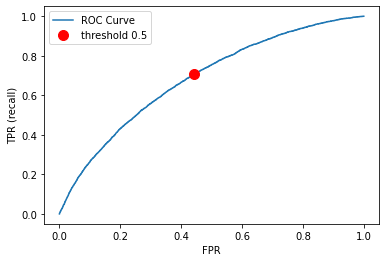

In [52]:
# plot_roc_curve(pipe_lr_balanced, X_train, y_train)

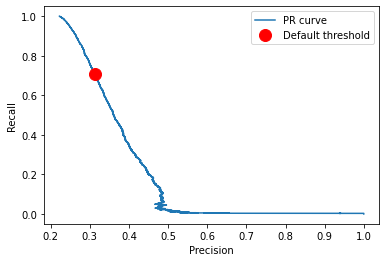

In [53]:
# precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
#     y_train, pipe_lr_balanced.predict_proba(X_train)[:, 1]
# )
# close_default_lr = np.argmin(np.abs(thresholds_lr - 0.5))

# plot_PR_curve(precision_lr, recall_lr, close_default_lr)

In [54]:
def get_scores(model, X, y, threshold):
    y_pred = model.predict_proba(X)[:, 1] > threshold
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    return {
        "Precision": precision,
        "Recall": recall,
        "f1": f1
    }

__Best threshold after hit and trial: 0.63__

In [55]:
get_scores(pipe_averaging, X_train, y_train, 0.63)

{'Precision': 0.5012772168835908,
 'Recall': 0.772880720180045,
 'f1': 0.6081310410979119}

In [56]:
X_test

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,percent_paid4,percent_paid5,percent_credit_utilised1,percent_credit_utilised2,percent_credit_utilised3,percent_credit_utilised4,percent_credit_utilised5,percent_credit_utilised6,std_dev_bill,std_dev_pay
25665,40000,2,2,2,26,-1,0,0,0,-1,...,50.820007,3.636947,72.477500,60.977500,34.000000,0.000000,110.060000,46.742500,14860.941954,8892.668450
16464,80000,2,3,1,59,0,0,0,0,0,...,3.182324,3.846776,94.577500,87.591250,66.461250,63.593750,62.965000,61.837500,11509.275414,553.609489
22386,170000,2,1,2,30,2,2,2,2,2,...,7.733768,3.217842,91.711765,93.422941,94.992353,92.692353,98.878824,100.542353,6060.739210,4678.318786
10149,200000,2,2,1,41,0,0,0,0,0,...,100.000000,100.000000,11.785000,0.367500,0.000000,0.000000,0.000000,0.000000,9566.918217,302.920232
8729,50000,1,2,1,43,0,0,0,0,0,...,3.621111,3.701778,16.428000,16.068000,18.088000,18.450000,18.834000,19.234000,651.842133,416.075474
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9940,160000,1,1,1,51,0,0,0,2,2,...,50.895765,0.000000,0.862500,0.925625,1.639375,1.535625,3.070000,2.293125,1349.663909,1225.878243
11351,70000,1,3,2,53,0,0,0,0,0,...,3.625966,3.579098,20.077143,21.540000,22.552857,23.000000,23.481429,23.948571,993.877994,428.534129
29732,10000,1,2,1,45,1,2,2,2,2,...,-0.000000,454.545455,63.210000,60.750000,100.620000,62.670000,-6.100000,-2.200000,4197.899352,1675.140790
9088,50000,1,3,0,50,0,0,0,-1,-1,...,100.000000,117.000000,91.542000,46.686000,0.000000,6.800000,5.538000,0.000000,18517.662395,1423.545773


In [57]:
get_scores(pipe_averaging, X_test, y_test, 0.63)

{'Precision': 0.3991270611057226,
 'Recall': 0.6311349693251533,
 'f1': 0.4890077243018419}